In [2]:
# Can I come up with a good reason for a scaling factor closer to X (1.35) than Armaan's (1.25)

# Spoiler: HF winds are too strong and make a big mess.  So just use X

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy.stats import moment

import downscaling_notCubed as ds

In [3]:
can07_u, can07_v = ds.import_CANRCM_winds(2007)
can07_mat = ds.transform2(can07_u, can07_v)
del can07_u
del can07_v
can07_PCs, can07_eigs, can07_mean = ds.doPCA(100, can07_mat)
del can07_mat

In [4]:
hr07_u, hr07_v = ds.import_HRDPS_winds(2007)

In [5]:
hr07_mat = ds.transform2(hr07_u, hr07_v)
hr07_PCs, hr07_eigs, hr07_mean = ds.doPCA(100, hr07_mat)
del hr07_mat

In [6]:
can07_me = np.concatenate((can07_mean.reshape(1, -1), can07_eigs))
hr07_me = np.concatenate((hr07_mean.reshape(1, -1), hr07_eigs))
del can07_eigs
del hr07_eigs

In [7]:
coefs = ds.getCoefs(can07_me, 65 + 1, hr07_me, 65 + 1, type = 'LS')

In [8]:
canTY_u, canTY_v = ds.import_CANRCM_winds(2007)
print ('step 0')
canTY_mat = ds.transform2(canTY_u, canTY_v)
del canTY_u
del canTY_v
mean_TY = canTY_mat.mean(axis = 0)

step 0


In [9]:
u_data_rec, v_data_rec = ds.reconstruct2(canTY_mat, mean_TY, can07_PCs, 
                                      can07_me, hr07_PCs, hr07_me, 65, 65, method = 'LS')

In [10]:
nspeed = (u_data_rec**2  + v_data_rec**2)**(0.5)
nangle = np.arctan2(v_data_rec, u_data_rec)

u_base = nspeed * np.cos(nangle)
v_base = nspeed * np.sin(nangle)

### Check that I have the same as ReconX

In [11]:
nspeed = 1.35*(u_data_rec**2  + v_data_rec**2)**(0.5)
nangle = np.arctan2(v_data_rec, u_data_rec)

u_asreconX = nspeed * np.cos(nangle)
v_asreconX = nspeed * np.sin(nangle)

In [12]:
oldreconX = xr.open_dataset('ncfiles/reconX_y2007m11d05.nc')

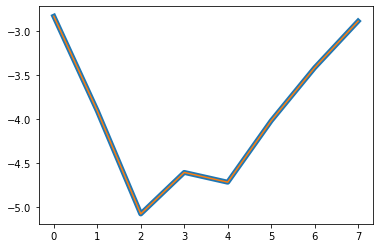

In [13]:
nit = 8*(31-2+28+31+30+31+30+31+31+30+31+4)
plt.plot(v_asreconX[nit:nit+8, 120, 160], linewidth=5);
plt.plot(oldreconX.v_wind[:, 120, 160]);

Yes, that would be the same! :-)

In [14]:
oldreconX.close()

In [11]:
hbi, hbj = 142,139
ssi, ssj = 174,107
shi, shj = 129,149
ii, jj = [hbi, ssi, shi], [hbj, ssj, shj]
labels = ['Halibut', 'Sentry', 'Sand Heads']

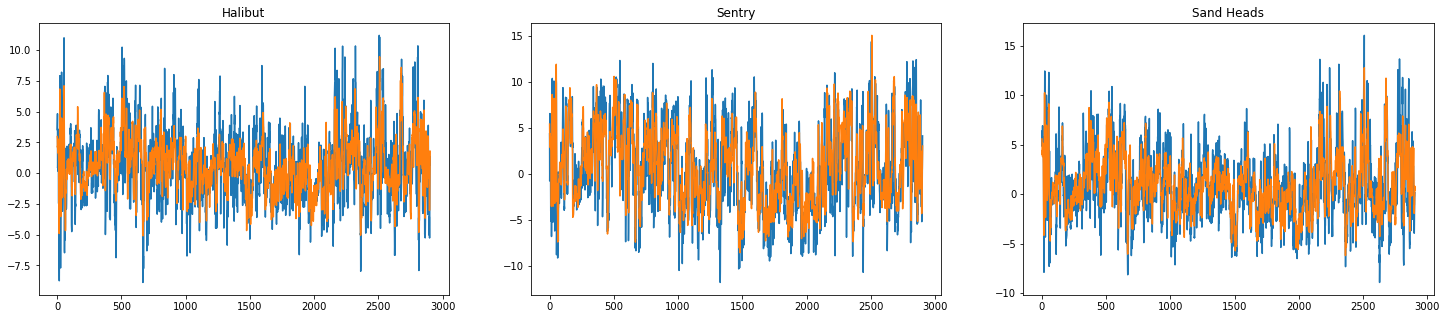

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    axs[axi].plot(hr07_v[:, iv, jv])
    axs[axi].plot(v_base[:, iv, jv])
    axs[axi].set_title(labels[axi])

In [37]:
def means(values):
    bias = values.mean()
    mabias = np.abs(values).mean()
    sqr = (values**2).mean()
    cubed = (values**3).mean()
    macubed = np.abs(values**3).mean()
    return bias, mabias, sqr, cubed, macubed

In [45]:
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    bias, mabias, sqr, cubed, macubed = means(hr07_v[:, iv, jv])
    bias2, mabias2, sqr2, cubed2, macubed2 = means(v_base[:, iv, jv])
    print (bias/bias2, mabias/mabias2, (sqr/sqr2)**0.5, (cubed/cubed2)**(1/3), (macubed/macubed2)**(1/3))

0.9543116362233242 1.3667211013560936 1.383239216052361 1.3181804622989666 1.3975529340004174
1.014291129046985 1.2271384231786673 1.2133220472673047 1.1447326016643153 1.200010049862122
0.9886685251491253 1.2835788417720748 1.3015855501165954 1.2543392031392326 1.2956961696677396


In [46]:
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    bias, mabias, sqr, cubed, macubed = means(hr07_u[:, iv, jv])
    bias2, mabias2, sqr2, cubed2, macubed2 = means(u_base[:, iv, jv])
    print (bias/bias2, mabias/mabias2, (sqr/sqr2)**0.5, (cubed/cubed2)**(1/3), (macubed/macubed2)**(1/3))

1.015430678219912 1.312814731552806 1.2500437424361364 1.1018542940197908 1.2157405689687377
0.9943393894074254 1.2147842162829976 1.2052544049801808 1.1895187284771682 1.201215729139902
0.6457128521006675 1.366211541978187 1.3336033437398473 1.585581763465011 1.3269109855928483


In [47]:
bias, mabias, sqr, cubed, macubed = means(hr07_v)
bias2, mabias2, sqr2, cubed2, macubed2 = means(v_base)
print (bias/bias2, mabias/mabias2, (sqr/sqr2)**0.5, (cubed/cubed2)**(1/3), (macubed/macubed2)**(1/3))

1.0006269168724338 1.2207431729357319 1.1792974686931936 1.1499006981285627 1.1746273086800088


In [48]:
bias, mabias, sqr, cubed, macubed = means(hr07_u)
bias2, mabias2, sqr2, cubed2, macubed2 = means(u_base)
print (bias/bias2, mabias/mabias2, (sqr/sqr2)**0.5, (cubed/cubed2)**(1/3), (macubed/macubed2)**(1/3))

0.999532497602121 1.260770605220407 1.2197971529654204 1.124951733827124 1.2139059421403273


In [50]:
bias, mabias, sqr, cubed, macubed = means(hr07_v[:, shi:ssi+1, ssj:shj+1])
bias2, mabias2, sqr2, cubed2, macubed2 = means(v_base[:, shi:ssi+1, ssj:shj+1])
print (bias/bias2, mabias/mabias2, (sqr/sqr2)**0.5, (cubed/cubed2)**(1/3), (macubed/macubed2)**(1/3))

0.9950439464038981 1.2945004763909191 1.2549839462473267 1.136413931288727 1.236852498545466


In [51]:
bias, mabias, sqr, cubed, macubed = means(hr07_u[:, shi:ssi+1, ssj:shj+1])
bias2, mabias2, sqr2, cubed2, macubed2 = means(u_base[:, shi:ssi+1, ssj:shj+1])
print (bias/bias2, mabias/mabias2, (sqr/sqr2)**0.5, (cubed/cubed2)**(1/3), (macubed/macubed2)**(1/3))

0.9937400067252793 1.3052847872453983 1.248710868094615 1.1715749409347394 1.233175801197859


In [64]:
def calculate_stats(origu, newu, origv, newv, ii, jj):
    stats = np.zeros((5))
    for axi, (iv, jv) in enumerate(zip(ii, jj)):
        bias, mabias, sqr, cubed, macubed = means(origu[:, iv, jv])
        bias2, mabias2, sqr2, cubed2, macubed2 = means(newu[:, iv, jv])
        stats[0] += bias/bias2
        stats[1] += mabias/mabias2
        stats[2] += (sqr/sqr2)**0.5
        stats[3] += (cubed/cubed2)**(1/3)
        stats[4] += (macubed/macubed2)**(1/3)
        bias, mabias, sqr, cubed, macubed = means(origv[:, iv, jv])
        bias2, mabias2, sqr2, cubed2, macubed2 = means(newv[:, iv, jv])
        stats[0] += bias/bias2
        stats[1] += mabias/mabias2
        stats[2] += (sqr/sqr2)**0.5
        stats[3] += (cubed/cubed2)**(1/3)
        stats[4] += (macubed/macubed2)**(1/3)
    return stats/6

In [65]:
calculate_stats(hr07_u, u_base, hr07_v, v_base, ii, jj)

array([0.93545904, 1.29520814, 1.28117472, 1.26570118, 1.27285441])

In [66]:
nspeed = (u_data_rec**2  + v_data_rec**2)**(0.5)
nangle = np.arctan2(v_data_rec, u_data_rec)

u_orig = 1.25 * nspeed * np.cos(nangle)
v_orig = 1.25 * nspeed * np.sin(nangle)

calculate_stats(hr07_u, u_orig, hr07_v, v_orig, ii, jj)

array([0.74836723, 1.03616651, 1.02493977, 1.01256094, 1.01828352])

In [67]:
nspeed = (u_data_rec**2  + v_data_rec**2)**(0.5)
nangle = np.arctan2(v_data_rec, u_data_rec)

u_X = 1.35 * nspeed * np.cos(nangle)
v_X = 1.35 * nspeed * np.sin(nangle)

calculate_stats(hr07_u, u_X, hr07_v, v_X, ii, jj)

array([0.69293262, 0.95941344, 0.94901831, 0.93755643, 0.94285512])

array([0.73082737, 1.01188136, 1.00091775, 0.98882904, 0.9944175 ])

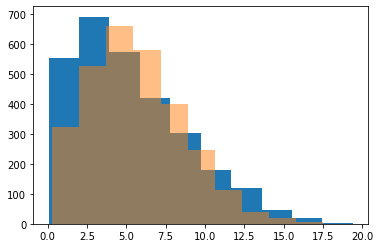

In [100]:
plt.hist(1.28*np.sqrt(u_base[:, hbi, hbj]**2 + v_base[:, hbi, hbj]**2));
plt.hist(np.sqrt(hr07_u[:, hbi, hbj]**2 + hr07_v[:, hbi, hbj]**2), alpha=0.5);
calculate_stats(hr07_u, 1.28*u_base, hr07_v, 1.28*v_base, ii, jj)

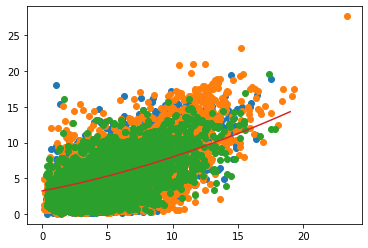

In [117]:
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    plt.plot(np.sqrt(hr07_u[:, iv, jv]**2 + hr07_v[:, iv, jv]**2), 1.28*np.sqrt(u_base[:, iv, jv]**2 + v_base[:, iv, jv]**2), 'o')
plt.plot(np.arange(0, 20), 3.23 + 0.356*np.arange(0, 20) + 0.012*np.arange(0, 20)**2)

In [116]:
y = (np.sqrt(hr07_u[:, hbi, hbj]**2 + hr07_v[:, hbi, hbj]**2)).reshape(-1, 1)
print (y.shape)
X = np.zeros((y.shape[0], 2))
print (X.shape)
X[:, 0] = 1.28*np.sqrt(u_base[:, hbi, hbj]**2 + v_base[:, hbi, hbj]**2)
X[:, 1] = X[:, 0]**2
reg = LinearRegression().fit(X, y)
#coefs[i] = reg.coef_[0:num_vec]
#intercept[i] =  reg.intercept_
reg.coef_, reg.intercept_

(2904, 1)
(2904, 2)


(array([[0.35648014, 0.01200072]]), array([3.2304522]))

In [119]:
def mani_hist(nspeed):
    nspeed = 1.28*nspeed
    nspeed = 3.23 + 0.356*nspeed + 0.012*nspeed**2
    return (nspeed)

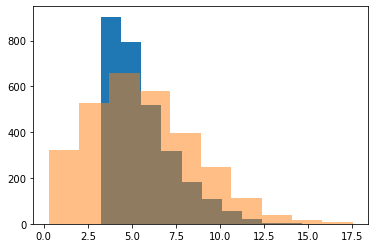

In [120]:
plt.hist(mani_hist(np.sqrt(u_base[:, hbi, hbj]**2 + v_base[:, hbi, hbj]**2)));
plt.hist(np.sqrt(hr07_u[:, hbi, hbj]**2 + hr07_v[:, hbi, hbj]**2), alpha=0.5);

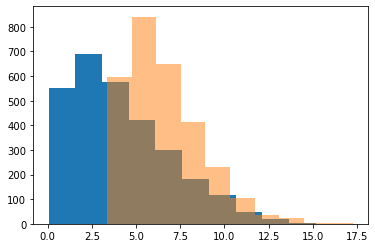

In [121]:
plt.hist((np.sqrt(u_base[:, hbi, hbj]**2 + v_base[:, hbi, hbj]**2)));
plt.hist(mani_hist(np.sqrt(hr07_u[:, hbi, hbj]**2 + hr07_v[:, hbi, hbj]**2)), alpha=0.5);

In [ ]:
A = a*x + b*x**2

5 = a*2.5 + b*2.5**2
15 = a*16 + b*16**2

5*16 = a*2.5*16 + b*2.5**2*16
15*2.5 = a*16*2.5 + b*16**2*2.5

5*16 - 15*2.5 = b*(2.5**2*16 - 16**2*2.5)

In [123]:
b = (5*16 - 15*2.5)/(2.5**2*16  - 16**2*2.5)
b

-0.0787037037037037

In [125]:
a = (5 - b*2.5**2)/2.5
a

2.196759259259259

In [366]:
speed = (np.sqrt(u_base[:, hbi, hbj]**2 + v_base[:, hbi, hbj]**2))

In [150]:
speed_manip = 1.5*speed +b*speed**2
bins = np.arange(0, 18, 0.5)

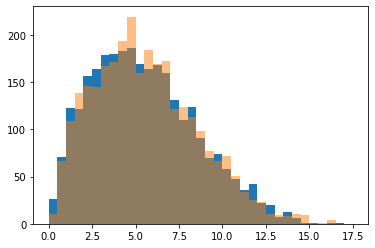

In [367]:
#speed_manip = 2.1*speed - 0.29*speed**1.5 + 0.001*speed*2
#speed_manip = 3*speed - 0.5*speed**1.5
speed_manip = newspeed_fn(speed)
mrs, sbins, obj = plt.hist(speed_manip, bins=bins)
#speed_manip = 1.7*speed - 0.04*speed**2
#plt.hist(speed_manip, bins=bins)
hrs, sbins, obj = plt.hist(np.sqrt(hr07_u[:, hbi, hbj]**2 + hr07_v[:, hbi, hbj]**2), bins=bins, alpha=0.5)

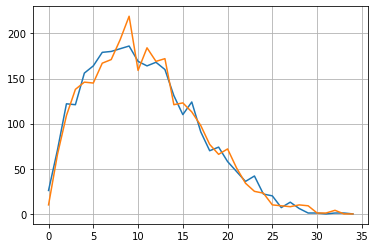

In [368]:
plt.plot(mrs)
plt.plot(hrs)
plt.grid()

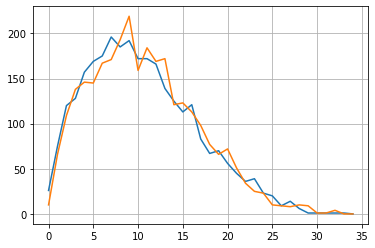

In [363]:
plt.plot(mrs)
plt.plot(hrs)
plt.grid()

In [309]:
def myspeed_fn(speed):
    speed[speed > 12] = speed[speed > 12] * 1.1
    speed[np.greater_equal(speed, 9) & np.less(speed, 12)] = speed[np.greater_equal(speed, 9) & np.less(speed, 12)] * 1.15
    speed[np.greater_equal(speed, 6) & np.less(speed, 9)] = speed[np.greater_equal(speed, 6) & np.less(speed, 9)] * 1.2
    speed[np.greater_equal(speed, 3) & np.less(speed, 6)] = speed[np.greater_equal(speed, 3) & np.less(speed, 6)] * 1.35
    speed[speed < 3] = speed[speed < 3] * 1.7
    return speed

In [353]:
x = np.array([1.5, 4.5, 7.5, 10.5, 16.5])
y = np.array([1.7, 1.35, 1.2, 1.15, 1.1])

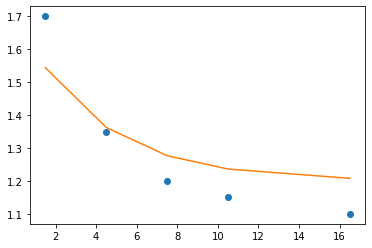

In [413]:
plt.plot(x, y, 'o')
plt.plot(x, 1.2+0.5*np.exp(-x/4))

In [414]:
def newspeed_fn(speed):
    multiplier = 1.07+0.93*np.exp(-speed/4)   # base on HB
    multiplier = 1.2+0.5*np.exp(-speed/4) # maybe better for SS? 0.4, 0.45 now 0.5
    speed = speed*multiplier
    return speed

In [415]:
speed = newspeed_fn(np.sqrt(u_base**2 + v_base**2))
nangle = np.arctan2(v_base, u_base)
new_u = speed * np.cos(nangle) 
new_v = speed * np.sin(nangle)
calculate_stats(hr07_u, new_u, hr07_v, new_v, ii, jj)

array([0.72565287, 0.96510469, 0.98258553, 1.00388256, 0.9944065 ])

array([0.73082737, 1.01188136, 1.00091775, 0.98882904, 0.9944175 ]) 1.28*
array([0.75913911, 0.97097315, 1.01178848, 1.06888416, 1.0407331 ]) HB Bank Fit
array([0.73564877, 0.98595759, 0.99870271, 1.01373285, 1.00727876]) SS first try
array([0.73060647, 0.97541872, 0.99059034, 1.00878789, 1.00081794]) SS second try (0.45)

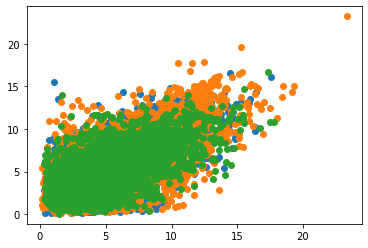

In [369]:
#HB
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    plt.plot(np.sqrt(hr07_u[:, iv, jv]**2 + hr07_v[:, iv, jv]**2), np.sqrt(new_u[:, iv, jv]**2 + new_v[:, iv, jv]**2), 'o')

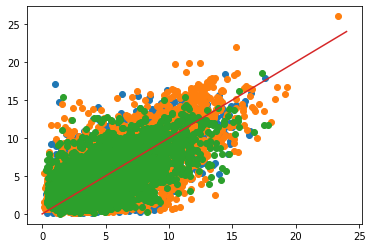

In [416]:
#SS?
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    plt.plot(np.sqrt(hr07_u[:, iv, jv]**2 + hr07_v[:, iv, jv]**2), np.sqrt(new_u[:, iv, jv]**2 + new_v[:, iv, jv]**2), 'o')
plt.plot(np.arange(0, 25), np.arange(0, 25), '-')

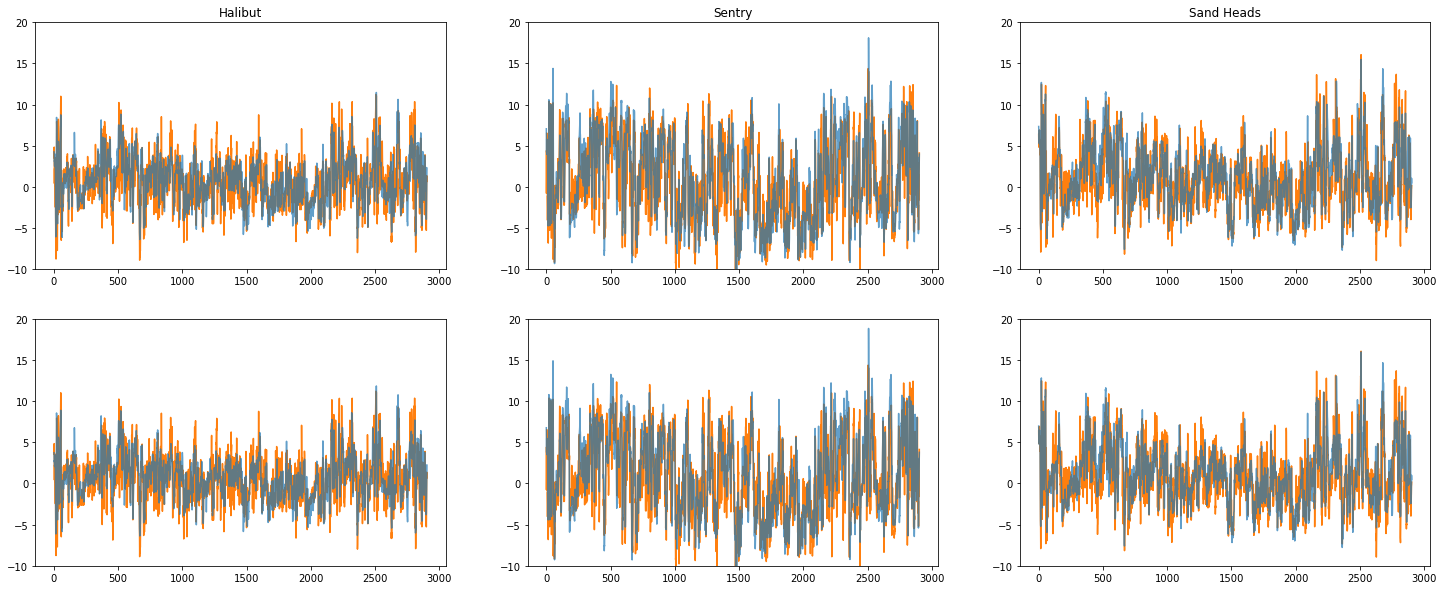

In [418]:
fig, axs = plt.subplots(2, 3, figsize=(25, 10))
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    axs[0, axi].plot(hr07_v[:, iv, jv], c='tab:orange')
    axs[0, axi].plot(new_v[:, iv, jv], c='tab:blue', alpha=0.7)
    axs[1, axi].plot(hr07_v[:, iv, jv], c='tab:orange')
    axs[1, axi].plot(1.25*v_base[:, iv, jv], c='tab:blue', alpha=0.7)
    axs[0, axi].set_title(labels[axi])
    for ax in axs[0]:
        ax.set_ylim(-10, 20)
    for ax in axs[1]:
        ax.set_ylim(-10, 20)

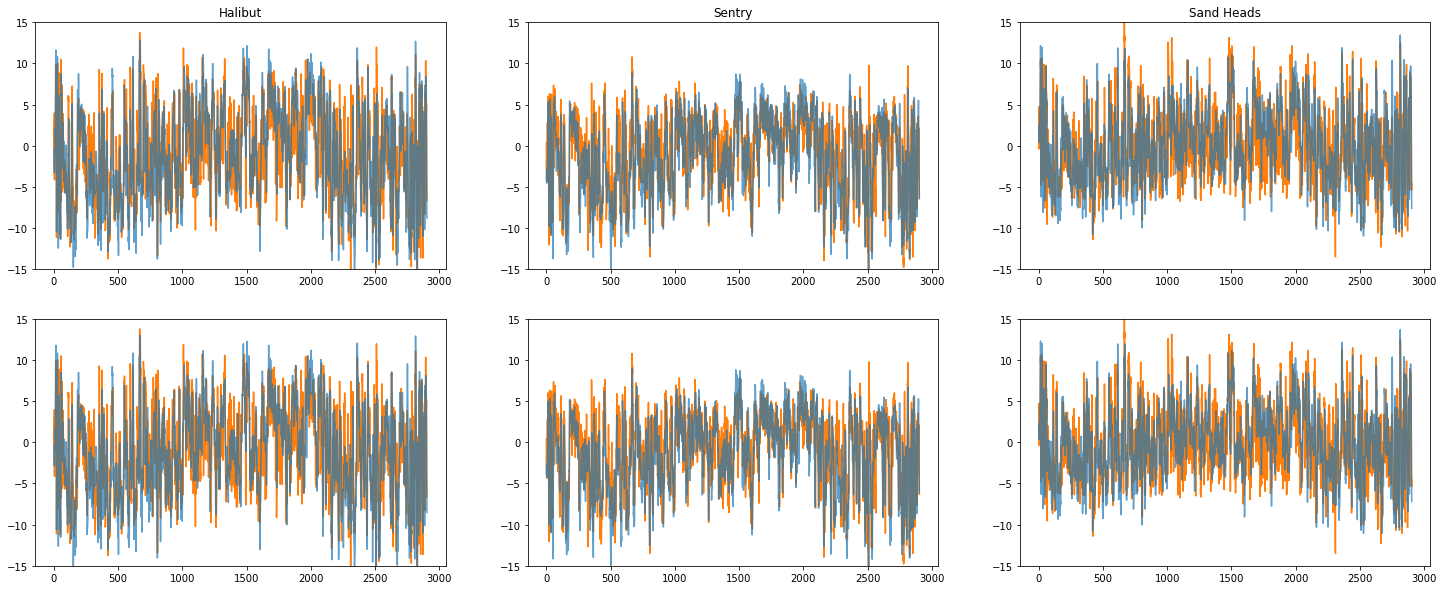

In [419]:
fig, axs = plt.subplots(2, 3, figsize=(25, 10))
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    axs[0, axi].plot(hr07_u[:, iv, jv], c='tab:orange')
    axs[0, axi].plot(new_u[:, iv, jv], c='tab:blue', alpha=0.7)
    axs[0, axi].set_title(labels[axi])
    axs[1, axi].plot(hr07_u[:, iv, jv], c='tab:orange')
    axs[1, axi].plot(1.25*u_base[:, iv, jv], c='tab:blue', alpha=0.7)
    for ax in axs[0]:
        ax.set_ylim(-15, 15)
    for ax in axs[1]:
        ax.set_ylim(-15, 15)

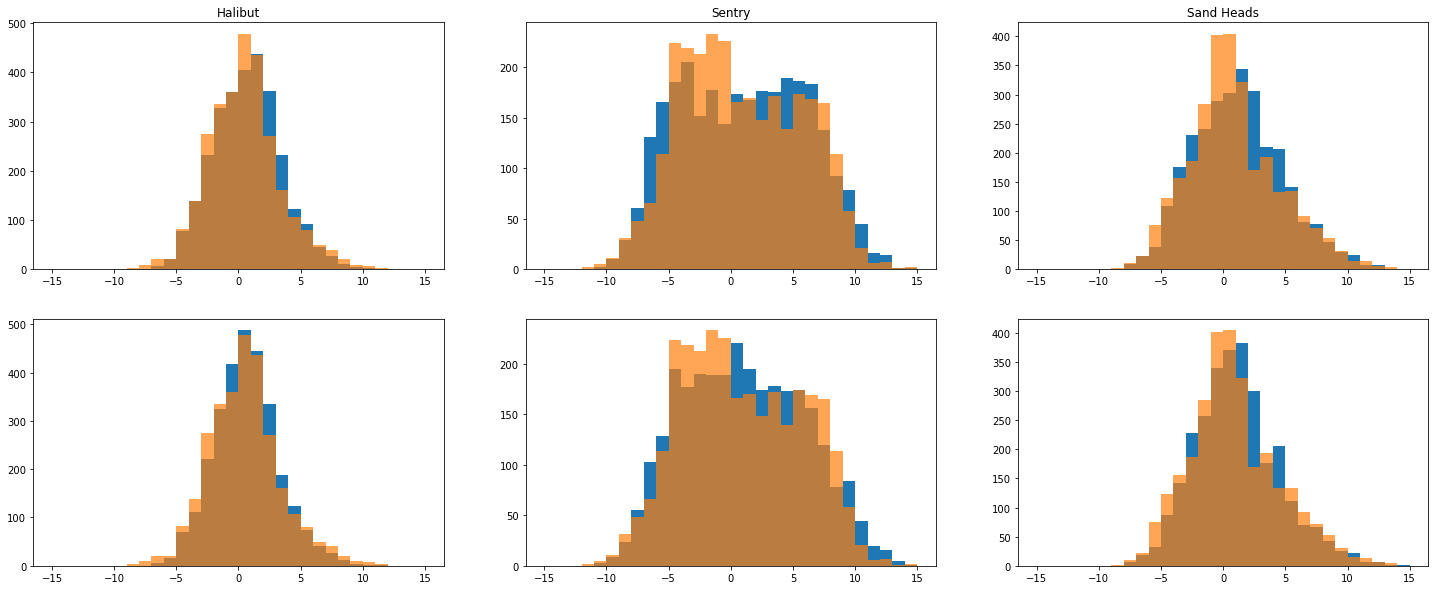

In [420]:
fig, axs = plt.subplots(2, 3, figsize=(25, 10))
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    bins = np.arange(-15, 16, 1)
    axs[0, axi].hist(new_v[:, iv, jv], bins=bins)
    axs[0, axi].hist(hr07_v[:, iv, jv], bins=bins, alpha=0.7)
    axs[1, axi].hist(1.25*v_base[:, iv, jv], bins=bins)
    axs[1, axi].hist(hr07_v[:, iv, jv], bins=bins, alpha=0.7)
    axs[0, axi].set_title(labels[axi])

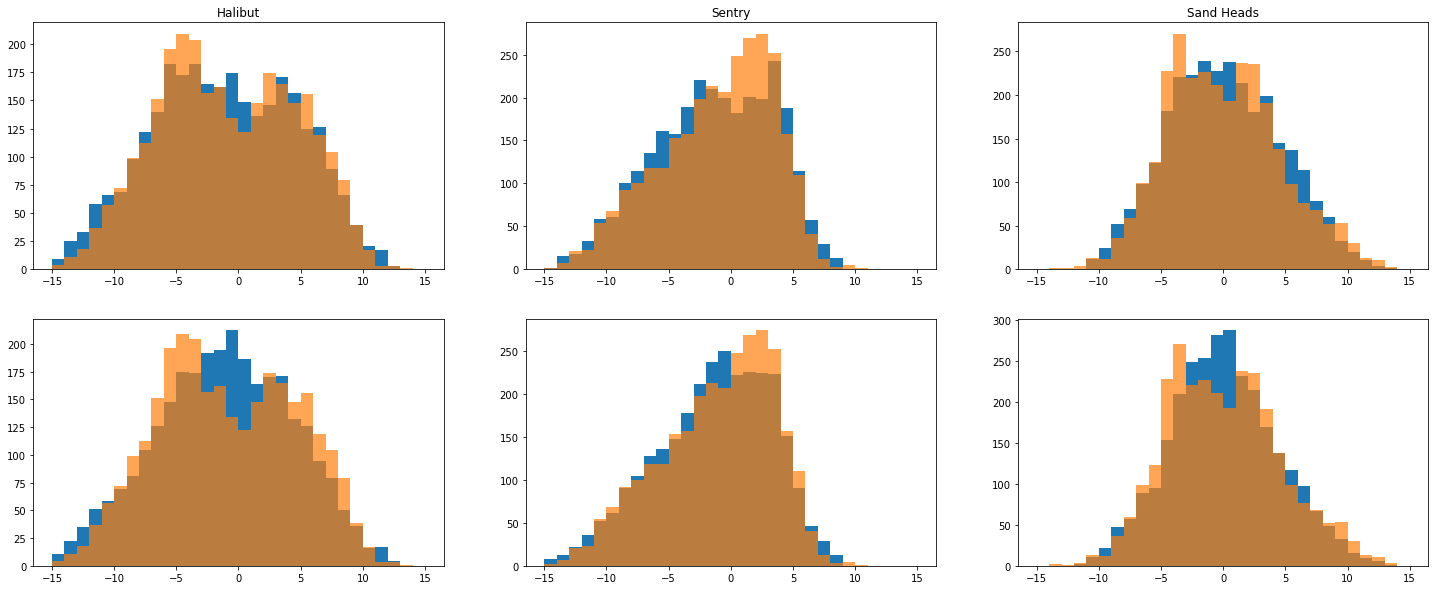

In [421]:
fig, axs = plt.subplots(2, 3, figsize=(25, 10))
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    bins = np.arange(-15, 16, 1)
    axs[0, axi].hist(new_u[:, iv, jv], bins=bins)
    axs[0, axi].hist(hr07_u[:, iv, jv], bins=bins, alpha=0.7)
    axs[1, axi].hist(1.25*u_base[:, iv, jv], bins=bins)
    axs[1, axi].hist(hr07_u[:, iv, jv], bins=bins, alpha=0.7)
    axs[0, axi].set_title(labels[axi])

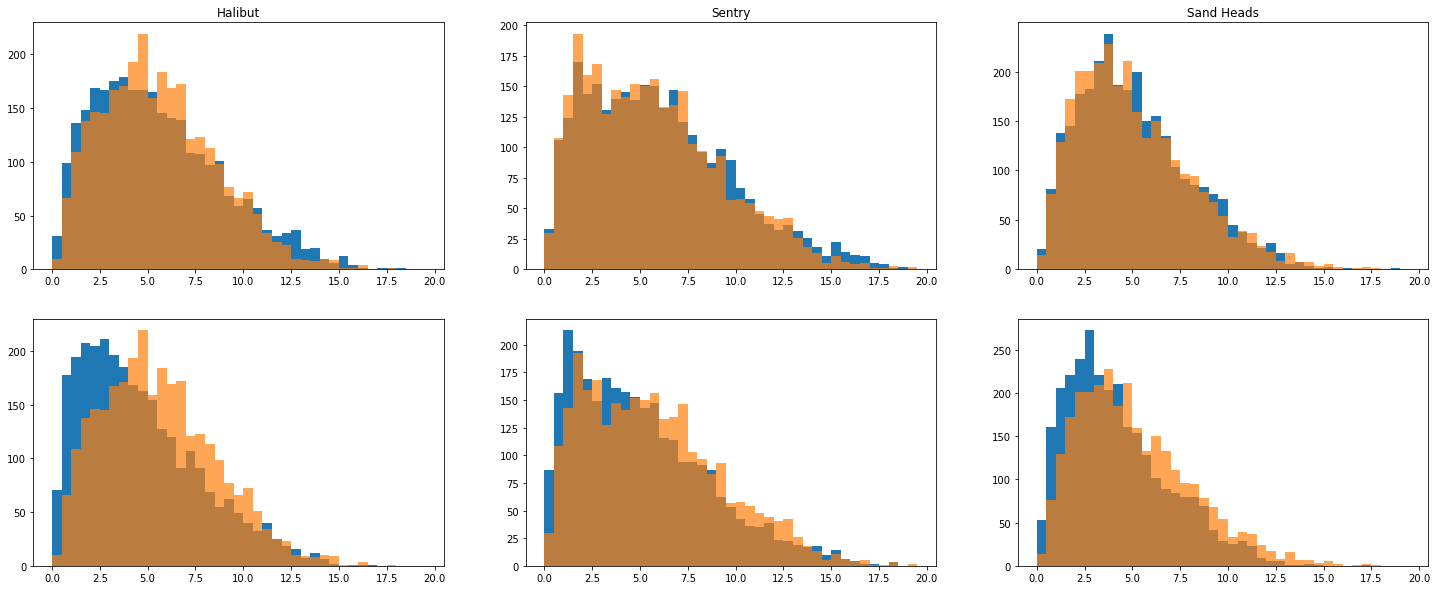

In [422]:
fig, axs = plt.subplots(2, 3, figsize=(25, 10))
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    bins = np.arange(0, 20, 0.5)
    axs[0, axi].hist(np.sqrt(new_v[:, iv, jv]**2 + new_u[:, iv, jv]**2), bins=bins)
    axs[0, axi].hist(np.sqrt(hr07_v[:, iv, jv]**2 + hr07_u[:, iv, jv]**2), bins=bins, alpha=0.7)
    axs[1, axi].hist(np.sqrt(1.25 * v_base[:, iv, jv]**2 + 1.25 * u_base[:, iv, jv]**2), bins=bins)
    axs[1, axi].hist(np.sqrt(hr07_v[:, iv, jv]**2 + hr07_u[:, iv, jv]**2), bins=bins, alpha=0.7)
    axs[0, axi].set_title(labels[axi])

Need to do the fit properly with MQ and all three histograms

In [55]:
bins = np.arange(0, 20, 0.5)
hr_speeds = np.empty((3, 2904))
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    hr_speeds[axi] = (np.sqrt(hr07_u[:, iv, jv]**2 + hr07_v[:, iv, jv]**2))
hrs = hr_speeds.flatten()
hh, sbins, obj = plt.hist(hrs, bins=bins)

In [75]:
mms = 5
hhmoments = np.empty((mms))
for mm in range(mms):
    hhmoments[mm] = moment(hrs, moment=mm)
hhmoments

array([  1.        ,   0.        ,  10.12119474,  23.36467665,
       336.46014318])

In [24]:
del hr07_u
del hr07_v

In [14]:
del u_data_rec
del v_data_rec

In [15]:
stack_speeds = np.empty((3, 2904))
for axi, (iv, jv) in enumerate(zip(ii, jj)):
    stack_speeds[axi] = (np.sqrt(u_base[:, iv, jv]**2 + v_base[:, iv, jv]**2))
ss = stack_speeds.flatten()

In [16]:
del u_base
del v_base

In [101]:
mms = 5
hhmoments = np.empty((mms))
for mm in range(mms):
    hhmoments[mm] = moment(hrs, moment=mm)
hhmoments

array([  1.        ,   0.        ,  10.12119474,  23.36467665,
       336.46014318])

In [102]:
def myfunction(ss, a, b, c):
       
    multiplier = a + b * np.exp(-ss/c)
    upd_speed = ss * multiplier
    
    mms = 5
    ssmoments = np.empty((mms))
    for mm in range(mms):
        ssmoments[mm] = moment(upd_speed, moment=mm)
        
#    mrs, sbins = np.histogram(upd_speed, bins=bins)
        
    return ssmoments

In [103]:
popt, pcov = curve_fit(myfunction, ss, hhmoments, p0=[1.2, 0.5, 4])

In [104]:
popt

array([1.10921473, 0.55272469, 4.56811431])

In [105]:
a, b, c = popt[0], popt[1], popt[2]
multiplier = a + b * np.exp(-ss/c)
newspeeds = ss * multiplier

23.036759921749148


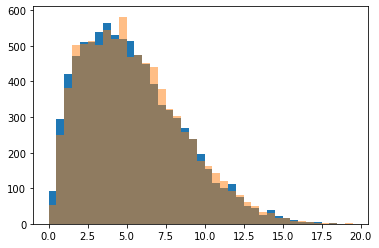

In [106]:
ass, sbins, obj = plt.hist(newspeeds, bins=bins);
bss, sbins, obj = plt.hist(hrs, bins=bins, alpha=0.5);
print ( np.sqrt(((ass-bss)**2).mean()))

58.00442069801939


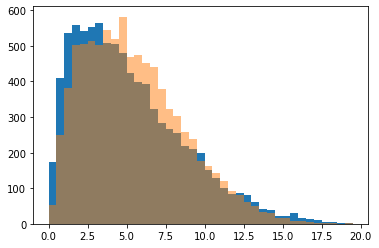

In [112]:
ass, sbins, obj = plt.hist(1.25*ss, bins=bins);
bss, sbins, obj = plt.hist(hrs, bins=bins, alpha=0.5);
print ( np.sqrt(((ass-bss)**2).mean()))

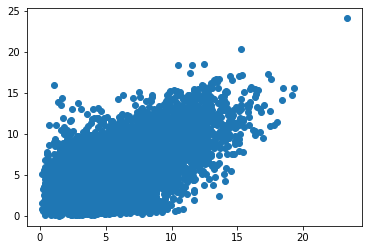

In [107]:
plt.plot(hrs, newspeeds, 'o');

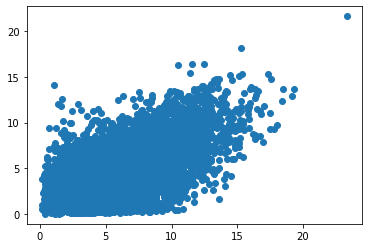

In [108]:
plt.plot(hrs, ss, 'o');